In [1]:
import numpy as np
import random

import keras
from keras import datasets, layers, models, preprocessing, backend

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import datasets, layers, models, preprocessing, backend

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw
import PIL.ImageOps

import json
import os

Using TensorFlow backend.


In [2]:
print(tf.__version__)

1.13.1


In [2]:
# testing with singapore carplate
# generate the cropped letter images from carplates
with open("cropped/data_bounding_box.json") as json_file:
    data = json.load(json_file)
    big_count = 0
    for path in data:
        plate = path.split('/')[1]
        count = 0
        for coord in data[path]:
            im = Image.open(path)
            if(not os.path.isdir('cropped/extracted_char/' + plate[count])):
                os.mkdir('cropped/extracted_char/' + plate[count])
            cropped = im.crop((coord[0][0], coord[0][1], coord[1][0], coord[1][1]))
            cropped.save('cropped/extracted_char/' + plate[count] + '/' + str(big_count) + '.jpg')
            count += 1
            big_count += 1  

In [89]:
# get avg width and height
avg_width, avg_height = 0, 0
with open("plate_data/cropped/data_bounding_box.json") as json_file:
    data = json.load(json_file)
    counter = 0
    for path in data:
        for coord in data[path]:
            avg_width += abs(coord[0][0] - coord[1][0])
            avg_height += abs(coord[0][1] - coord[1][1])
            counter += 1
    avg_width = int(avg_width / counter)
    avg_height = int(avg_height / counter)
print(avg_height, avg_width)

26 18


In [3]:
# inverting colours
for name in os.listdir('char_data'):
        path = 'char_data/' + name
        img = Image.open(path)
        PIL.ImageOps.invert(img.convert('RGB')).save(path)

In [230]:
#keras.backend.clear_session()
datagen = preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    fill_mode = 'constant',
#     rotation_range = 2,
#     zoom_range = (0.8, 0.9),
#     width_shift_range = (-0.5, 0.5),
    validation_split = 0.1
)

traingen = datagen.flow_from_directory(
    r'./char_data/collected',
    target_size = (30, 20),
    #save_to_dir = './char_data/default_aug_3x2',
    subset = 'training'
)

valgen = datagen.flow_from_directory(
    r'./char_data/collected',
    target_size = (30, 20),
    #save_to_dir = './char_data/default_aug_3x2',
    subset = 'validation'
)

#testing the generator
# i = 0
# for batch in datagen.flow_from_directory(
#     r'./generator',
#     target_size = (30, 20),
#     save_to_dir = './generator',
# ):
#     i += 1
#     if i > 20:
#         break

Found 3050 images belonging to 34 classes.
Found 323 images belonging to 34 classes.


In [242]:
# create new model / restart model
keras.backend.clear_session()
input_shape = (30, 20, 3)
# model = models.Sequential()
# model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
# model.add(layers.Dropout(0.20))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.Dropout(0.20))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.Dropout(0.20))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.20))
# model.add(layers.Dense(34, activation='softmax'))
model = models.Sequential([
layers.Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
# layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
# layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
# layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
# layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
# layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
# layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
# layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
# layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
# layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
# layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
# layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
# layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
layers.Flatten(),
layers.Dense(1024, activation='relu'),
# layers.Dropout(0.20),    
layers.Dense(1024, activation='relu'),
# layers.Dropout(0.20),
layers.Dense(34, activation='softmax')
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 20, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 10, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4480)              0         
__________

In [243]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("charcollectedvgg.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [244]:
hist = model.fit_generator(steps_per_epoch=50, generator=traingen, validation_data=valgen, validation_steps=10, epochs=100, callbacks=[checkpoint, early])

Epoch 1/100
50/50 [==============================] - 20s 396ms/step - loss: 2.4713 - acc: 0.3325 - val_loss: 0.9274 - val_acc: 0.6735

Epoch 00001: val_acc improved from -inf to 0.67354, saving model to charcollectedvgg.h5
Epoch 2/100
50/50 [==============================] - 28s 567ms/step - loss: 0.4763 - acc: 0.8654 - val_loss: 0.4763 - val_acc: 0.8900

Epoch 00002: val_acc improved from 0.67354 to 0.89003, saving model to charcollectedvgg.h5
Epoch 3/100
50/50 [==============================] - 26s 529ms/step - loss: 0.1857 - acc: 0.9575 - val_loss: 0.1653 - val_acc: 0.9450

Epoch 00003: val_acc improved from 0.89003 to 0.94502, saving model to charcollectedvgg.h5
Epoch 4/100
50/50 [==============================] - 18s 369ms/step - loss: 0.1419 - acc: 0.9575 - val_loss: 0.1389 - val_acc: 0.9759

Epoch 00004: val_acc improved from 0.94502 to 0.97595, saving model to charcollectedvgg.h5
Epoch 5/100
50/50 [==============================] - 29s 582ms/step - loss: 0.1094 - acc: 0.9738 - 

KeyboardInterrupt: 

In [245]:
# upload the new architecture (to vgg)
model_json = model.to_json()
with open("charcollectedvgg.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# model.save_weights("def2.h5")
# print("Saved model to disk")

In [12]:
# get best weight
# keras.backend.clear_session()
json_file = open('charcollectedvgg.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
tmodel = models.model_from_json(loaded_model_json)
tmodel.load_weights("charcollectedvgg.h5")

B [  1.47613100e-09   3.20274083e-08   7.45977729e-07   2.47700651e-08
   3.71003246e-08   4.22565455e-10   2.79002439e-08   9.68104086e-09
   2.65024234e-08   1.10002429e-09   1.45485499e-08   9.99864578e-01
   2.62613181e-10   1.34290080e-04   1.66245306e-09   2.25510985e-10
   1.20348467e-10   2.41800624e-09   4.22031811e-12   1.36978144e-08
   3.20022758e-10   7.58000507e-09   1.01778119e-09   1.01001596e-07
   1.70639503e-09   4.24311999e-08   8.65676475e-10   4.73496709e-09
   6.68748079e-09   5.81902304e-09   3.90668331e-10   3.83828885e-10
   6.76634582e-10   1.08849774e-08]


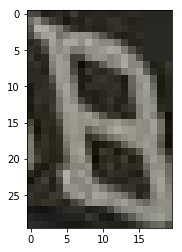

In [13]:
im = Image.open('char_data/collected/B/1042.jpg')
im = im.resize((20, 30))
draw = ImageDraw.Draw(im)
plt.figure()
plt.imshow(np.asarray(im))
ini = np.array([np.asarray(im)]) / 255
out = tmodel.predict(ini)[0]
dicta = '0123456789ABCDEFGHJKLMNPQRSTUVWXYZ'
maxi = 0
idx = 0
for i in range(0, len(out)):
    if i == 0:
        maxi = out[i]
    elif(out[i] > maxi):
        maxi = out[i]
        idx = i
print(dicta[idx], out)

In [37]:
datagen = preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    fill_mode = 'constant',
    rotation_range = 5,
    zoom_range = (0.8, 1.2)
)

testgen = datagen.flow_from_directory(
    r'./char_data/collected',
    target_size = (30, 20)
)

Found 3373 images belonging to 34 classes.


In [42]:
tmodel.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
meanacc = 0
for i in range(10):
    meanacc += tmodel.evaluate_generator(testgen, steps=3373/32)[1]
meanacc /= 10
print(meanacc)

0.973584346283


In [43]:
dirr = 'char_data/collected'
for cur_char in os.listdir(dirr):
        correct = 0
        for img in os.listdir(dirr + '/' + cur_char):
            im = Image.open(dirr + '/' + cur_char + '/' + img)
            im = im.resize((20, 30), Image.ANTIALIAS)
            ini = np.array([np.asarray(im)]) / 255
            out = tmodel.predict(ini)[0]
            dicta = '0123456789ABCDEFGHJKLMNPQRSTUVWXYZ'
            maxi = 0
            idx = 0
            for i in range(0, len(out)):
                if i == 0:
                    maxi = out[i]
                elif(out[i] > maxi):
                    maxi = out[i]
                    idx = i
            correct += 1 if dicta[idx] == cur_char else 0
        total = len(os.listdir(dirr + '/' + cur_char))
        if total != 0:
            print('%c: %i percent' % (cur_char, round(correct / total * 100, 2)))
            

0: 97 percent
1: 100 percent
2: 100 percent
3: 99 percent
4: 100 percent
5: 100 percent
6: 100 percent
7: 100 percent
8: 99 percent
9: 100 percent
A: 97 percent
B: 100 percent
C: 100 percent
D: 100 percent
E: 100 percent
F: 100 percent
G: 97 percent
H: 100 percent
J: 98 percent
K: 100 percent
L: 100 percent
M: 98 percent
N: 100 percent
P: 99 percent
Q: 100 percent
R: 100 percent
S: 99 percent
T: 100 percent
U: 100 percent
V: 100 percent
W: 100 percent
X: 100 percent
Y: 100 percent
Z: 100 percent


In [36]:
f = backend.function([model.layers[0].input, backend.learning_phase()], [model.layers[-1].output])
def predict_with_uncertainty(f, x, n_iter=10):
    result = np.zeros((n_iter,) + x.shape)
    for iter in range(n_iter):
        result[iter] = f(x, 1)

    prediction = result.mean(axis=0)
    uncertainty = result.var(axis=0)
    return prediction, uncertainty

In [37]:
img = "test/_1306_4084982.png"
im = Image.open(img)

ini = np.array([np.asarray(im)]) / 255
print(predict_with_uncertainty(f, ini))

out = model.predict(ini)[0]
dicta = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
maxi = 0
idx = 0
print(out)
for i in range(0, len(out)):
    if i == 0:
        maxi = out[i]
    elif(out[i] > maxi):
        maxi = out[i]
        idx = i
print(dicta[idx])

    

ValueError: could not broadcast input array from shape (1,1,36) into shape (1,32,32,3)